### Hannah Padgette, Haley Teil, and Bailey Zinger
### Mathematical & Computational Modeling of Infectious Diseases
### D.B. Larremore
### Final Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

#### SIAD Model - HIV Infection in Adults with no Interventions

We first sought to develop a basic compartmental model of HIV-1 infection which was accurate to both transmission and infection dynamics. This model is a so-called SIAD model, wherein susceptible individuals contract HIV-1 via contact with individuals in the I (HIV-1 infected and infectious) and A (AIDS) compartments. In the absence of any intervention, we assume that everybody who is HIV-1 infected and infectious (I) will progress to AIDS (A), at a rate based on real-world observations. Again, in the absence of any interventions we assume that people who have acquired AIDS will eventually succumb to the disease and enter a deceased compartment, D. The differential equations which describe the dynamics of this system are as follows:

$$\dot{s} = \frac{ds}{dt} = -(\beta_i si + \beta_a sa)$$

$$\dot{i} = \frac{di}{dt} = \beta_i si + \beta_a sa - \lambda i$$

$$\dot{a} = \frac{da}{dt} = \lambda i - \mu a$$

$$\dot{d} = \frac{dd}{dt} = \mu a$$

Here, we employ Forward Euler's method to obtain numerical solutions for this system of first-order ordinary differential equations (ODEs). In order to use this procedure, we must define initial conditions and parameter values. The initial conditions are the initial fractions of the population being studied which are in each compartment. Since our system is normalized, our initial conditions must satisfy the following condition: 

$$ s_0 + i_0 + a_0 + d_0 = 1 $$

The goal of our project is to build upon this model to identify mechanisms through which the HIV-1 epidemic can be eradicated. Thus, we chose to make the initial conditions for our model realistic to current HIV-1 / AIDS prevalence in susceptible adults:

* $s_0 = 0.855$
* $i_0 = 0.114$
* $a_0 = 0.031$
* $d_0 = 0.00$

We also chose parameter values which are realistic to what we know about HIV-1 transmission and infection dynamics:  

* $\beta_i = 0.03749 \text{ day}^{-1}$
* $\beta_a = 0.01956 \text{ day}^{-1}$  or $0.00978 \text{ day}^{-1}$
* $\lambda = 0.0301 \text{ day}^{-1}$ 
* $\mu = 0.004089 \text{ day}^{-1}$ 

In [2]:
def SIAD(s0, i0, a0, d0, t0, tf, delta_t, params): 
    '''
    A function which uses forward Euler's method to solve the (normalized) SIAD model for a HIV-1 susceptible population.
    
    Inputs: 
        s0 = an initial condition for the susceptible population, normalized
        i0 = an initial condition for the HIV-infected and infectious population, normalized 
        a0 = an initial condition for the AIDS population, normalized
        d0 = an initial condition for the deceased population, normalized
        t0 = the starting time for the simulation, in days
        tf = the ending time for the simultion, in days
        delta_t = the time-step for Forward Euler's method, in days
        params = a 4x1 vector of the model parameters, with form: [[beta1],[beta2],[lamda],[mu]]

    Outputs: 
        (s,i,a,d,t) = vectors for the solutions of the diffeqs - s(t), i(t), a(t), d(t) - and the time vector - t
    '''
    
    n = int((tf-t0)/delta_t+1) # count the number of timepoints
    t = np.linspace(t0,tf,n)   # create a time vector 

    s = np.zeros(n)            # initialize a vector for the solution of ds/dt -> s(t)
    i = np.zeros(n)            # initialize a vector for the solution of di/dt -> i(t)
    a = np.zeros(n)            # initialize a vector for the solution of da/dt -> a(t)
    d = np.zeros(n)            # initialize a vector for the solution of dd/dt -> d(t)

    s[0]=s0 # define the first point in s(t)
    i[0]=i0 # define the first point in i(t)
    a[0]=a0 # define the first point in a(t)
    d[0]=d0 # define the first point in d(t)

    # unpack model parameters from params vector input into the function
    betai = params[0,0]
    betaa = params[1,0]
    lamda = params[2,0]
    mu = params[3,0]

    for x in range(1,len(t)): # loop thru each solution vector starting at index 1 
        s[x] = s[x-1] + delta_t * (-(betai*s[x-1]*i[x-1]+betaa*s[x-1]*a[x-1]))
        i[x] = i[x-1] + delta_t * (betai*s[x-1]*i[x-1]+betaa*s[x-1]*a[x-1]-lamda*i[x-1])
        a[x] = a[x-1] + delta_t * (lamda*i[x-1]-mu*a[x-1])
        d[x] = d[x-1] + delta_t * (mu*a[x-1])

    return (s,i,a,d,t)

#### SIADTD Model - HIV Infection in Adults with Diagnosis and ART Treatment

We next developed a compartmental model of HIV-1 infection which included diagnosis and treatment with ARTs. This is a so-called SIADTD model. In the absense of diagnosis and treatment, individuals proceed down the SIAD pipeline. If infected individuals undergo testing and receive a positive diagnosis, they transfer into a $d_x$ (diagnosed) compartment. In the absense of treatment post, diagnosis, they acquire AIDS ($a_{d_x}$) and then pass away ($d_{d_x}$). If they receive treatment, they are transferred from $d_x$ to a treatment compartment, $t_r$. They can exit the treatment compartment and return back to $d_x$, which reflects termination of treatment and/or imperfect compliance with treatments plans. The differential equations which describe the dynamics of this system are as follows:

$$\dot{s} = \frac{ds}{dt} = -(\beta_i si + \beta_a sa)$$

$$\dot{i} = \frac{di}{dt} = \beta_i si + \beta_a sa - \lambda i - \theta i$$

$$\dot{a} = \frac{da}{dt} = \lambda i - \mu a$$

$$\dot{d} = \frac{dd}{dt} = \mu a$$

$$\dot{d_x} = \frac{dd_x}{dt} = \theta i - \lambda_{d_x} d_{d_x} - \kappa d_x + \xi t_r$$

$$\dot{a_{d_x}} = \frac{da_{d_x}}{dt} = \lambda_{d_x} d_{d_x} - \mu_{d_x} a_{d_x}$$

$$\dot{d_{d_x}} = \frac{dd_{d_x}}{dt} = \mu_{d_x} a_{d_x}$$

$$\dot{t_r} = \frac{dt_r}{dt} = \kappa d_x - \xi t_r$$

Our initial conditions are as follows:

* $s_0 = 0.855$
* $i_0 = 0.114$
* $a_0 = 0.031$
* $d_0 = 0.00$
* $d_x = 0.00$
* $a_{d_x} = 0.00$
* $d_{d_x} = 0.00$
* $t_r = 0.00$

We also chose parameter values which are realistic to what we know about HIV-1 transmission and infection dynamics:  

* $\beta_i = 0.03749 \text{ day}^{-1}$
* $\beta_a = 0.01956 \text{ day}^{-1}$ 
* $\lambda = 0.0301 \text{ day}^{-1}$ 
* $\mu = 0.004089 \text{ day}^{-1}$ 
* $\theta = 0.0101137 \text{ day}^{-1}$ 
* $\lambda_{d_x} = 0.00068493 \text{ day}^{-1}$ 
* $\mu_{d_x} = 0.004089 \text{ day}^{-1}$ 
* $\kappa = 0.00205479 \text{ day}^{-1}$ 
* $\xi = 0.00126028 \text{ day}^{-1}$ 

In [3]:
def SIADTD(s0, i0, a0, d0, dx0, adx0, ddx0, tr0, t0, tf, delta_t, params): 
    '''
    A function which uses forward Euler's method to solve the (normalized) SIADTD model for a HIV-1 susceptible population.
    
    Inputs: 
        s0 = an initial condition for the susceptible population, normalized
        i0 = an initial condition for the HIV-infected and infectious population, normalized 
        a0 = an initial condition for the AIDS population, normalized
        d0 = an initial condition for the deceased population, normalized
        dx0 = an initial condition for the HIV-1 diagnosed population, normalized
        adx0 = an initial condition for the AIDS population, diagnosed, normalized
        ddx0 = an initial condition for the deceased population, diagnosed, normalized
        tr0 = an initial condition for the treatment population, normalized
        t0 = the starting time for the simulation, in days
        tf = the ending time for the simultion, in days
        delta_t = the time-step for Forward Euler's method, in days
        params = a 9x1 vector of the model parameters, with form: [[beta1],[beta2],[lamda],[mu],[theta],[lamda_dx],[mu_dx],[kappa],[xi]]

    Outputs: 
        (s,i,a,d,dx,adx,ddx,tr,t) = vectors for the solutions of the diffeqs - s(t), i(t), a(t), d(t), dx(t), adx(t), ddx(t), tr(t) - and the time vector - t
    '''
    
    n = int((tf-t0)/delta_t+1) # count the number of timepoints
    t = np.linspace(t0,tf,n)   # create a time vector 

    s = np.zeros(n)            # initialize a vector for the solution of ds/dt -> s(t)
    i = np.zeros(n)            # initialize a vector for the solution of di/dt -> i(t)
    a = np.zeros(n)            # initialize a vector for the solution of da/dt -> a(t)
    d = np.zeros(n)            # initialize a vector for the solution of dd/dt -> d(t)
    dx = np.zeros(n)           # initialize a vector for the solution of ddx/dt -> d(t)
    adx = np.zeros(n)          # initialize a vector for the solution of dadx/dt -> d(t)
    ddx = np.zeros(n)          # initialize a vector for the solution of ddx/dt -> d(t)
    tr = np.zeros(n)           # initialize a vector for the solution of dtr/dt -> d(t)

    s[0]=s0      # define the first point in s(t)
    i[0]=i0      # define the first point in i(t)
    a[0]=a0      # define the first point in a(t)
    d[0]=d0      # define the first point in d(t)
    dx[0]=dx0    # define the first point in dx(t)
    adx[0]=adx0  # define the first point in adx(t)
    ddx[0]=ddx0  # define the first point in ddx(t)
    tr[0]=tr0    # define the first point in tr(t)

    # unpack model parameters from params vector input into the function
    betai = params[0,0]
    betaa = params[1,0]
    lamda = params[2,0]
    mu = params[3,0]
    theta = params[4,0]
    lamda_dx = params[5,0]
    mu_dx = params[6,0]
    kappa = params[7,0]
    xi = params[8,0]

    for x in range(1,len(t)): # loop thru each solution vector starting at index 1 
        s[x] = s[x-1] + delta_t * (-(betai*s[x-1]*i[x-1]+betaa*s[x-1]*a[x-1]))
        i[x] = i[x-1] + delta_t * (betai*s[x-1]*i[x-1]+betaa*s[x-1]*a[x-1]-lamda*i[x-1]-theta*i[x-1])
        a[x] = a[x-1] + delta_t * (lamda*i[x-1]-mu*a[x-1])
        d[x] = d[x-1] + delta_t * (mu*a[x-1])
        dx[x] = dx[x-1] + delta_t * (theta*i[x-1]-lamda_dx*dx[x-1]-kappa*dx[x-1]+xi*tr[x-1])
        adx[x] = adx[x-1] + delta_t * (lamda_dx*dx[x-1]-mu_dx*adx[x-1])
        ddx[x] = ddx[x-1] + delta_t * (mu_dx*adx[x-1])
        tr[x] = tr[x-1] + delta_t * (kappa*dx[x-1]-xi*tr[x-1])

    return (s,i,a,d,dx,adx,ddx,tr,t)

#### SPIAD Model - HIV Infection in Adults with PrEP Usage

Our SPIAD model is one which takes our basic infection model, SIAD, and accounts for PrEP usage in the population. Rather than modelling PrEP users to be in their own explicit compartment, we rather modelled usage as a decrease in the transmissibility of HIV-1. Our governing differential equations are therefore as follows

$$\dot{s} = \frac{ds}{dt} = -(\beta_i \cdot (1-PE \cdot r) \cdot si + \beta_a \cdot (1-PE \cdot r) \cdot sa)$$

$$\dot{i} = \frac{di}{dt} = \beta_i \cdot (1-PE \cdot r) \cdot si + \beta_a \cdot (1-PE \cdot r) \cdot sa - \lambda i$$

$$\dot{a} = \frac{da}{dt} = \lambda i - \mu a$$

$$\dot{d} = \frac{dd}{dt} = \mu a$$

Where $PE$ is the effectiveness of PrEP usage and $r$ is the adherance probability (?).

Our initial conditions are: 

* $s_0 = 0.855$
* $i_0 = 0.114$
* $a_0 = 0.031$
* $d_0 = 0.00$

And our parameters are as follows:  

* $\beta_i = 0.03749 \text{ day}^{-1}$
* $\beta_a = 0.01956 \text{ day}^{-1}$ 
* $\lambda = 0.0301 \text{ day}^{-1}$ 
* $\mu = 0.004089 \text{ day}^{-1}$ 
* $PE = 0.99$ for intercourse and $0.74$ for injection
* $r = 0.6249$

In [4]:
def SPIAD(s0, i0, a0, d0, t0, tf, delta_t, params): 
    '''
    A function which uses forward Euler's method to solve the (normalized) SPIAD model for a HIV-1 susceptible population.
    
    Inputs: 
        s0 = an initial condition for the susceptible population, normalized
        i0 = an initial condition for the HIV-infected and infectious population, normalized 
        a0 = an initial condition for the AIDS population, normalized
        d0 = an initial condition for the deceased population, normalized
        t0 = the starting time for the simulation, in days
        tf = the ending time for the simultion, in days
        delta_t = the time-step for Forward Euler's method, in days
        params = a 6x1 vector of the model parameters, with form: [[beta1],[beta2],[lamda],[mu],[PE],[r]]

    Outputs: 
        (s,i,a,d,t) = vectors for the solutions of the diffeqs - s(t), i(t), a(t), d(t) - and the time vector - t
    '''
    
    n = int((tf-t0)/delta_t+1) # count the number of timepoints
    t = np.linspace(t0,tf,n)   # create a time vector 

    s = np.zeros(n)            # initialize a vector for the solution of ds/dt -> s(t)
    i = np.zeros(n)            # initialize a vector for the solution of di/dt -> i(t)
    a = np.zeros(n)            # initialize a vector for the solution of da/dt -> a(t)
    d = np.zeros(n)            # initialize a vector for the solution of dd/dt -> d(t)

    s[0]=s0 # define the first point in s(t)
    i[0]=i0 # define the first point in i(t)
    a[0]=a0 # define the first point in a(t)
    d[0]=d0 # define the first point in d(t)

    # unpack model parameters from params vector input into the function
    betai = params[0,0]
    betaa = params[1,0]
    lamda = params[2,0]
    mu = params[3,0]
    PE = params[4,0]
    r = params[5,0]

    for x in range(1,len(t)): # loop thru each solution vector starting at index 1 
        s[x] = s[x-1] + delta_t * (-(betai*(1-PE*r)*s[x-1]*i[x-1]+betaa*(1-PE*r)*s[x-1]*a[x-1]))
        i[x] = i[x-1] + delta_t * (betai*(1-PE*r)*s[x-1]*i[x-1]+betaa*(1-PE*r)*s[x-1]*a[x-1]-lamda*i[x-1])
        a[x] = a[x-1] + delta_t * (lamda*i[x-1]-mu*a[x-1])
        d[x] = d[x-1] + delta_t * (mu*a[x-1])

    return (s,i,a,d,t)

#### SPIADTD Model - HIV Infection in Adults with PrEP Usage, Diagnosis, and ART Treatment

We next developed a compartmental model of HIV-1 infection which included PrEP usage, diagnosis, and treatment with ARTs. This is a combination of our SIADTD and SPIAD models The differential equations which describe the dynamics of this system are as follows:

$$\dot{s} = \frac{ds}{dt} = -(\beta_i \cdot (1-PE \cdot r) \cdot si + \beta_a \cdot (1-PE \cdot r) \cdot sa)$$

$$\dot{i} = \frac{di}{dt} = \beta_i \cdot (1-PE \cdot r) \cdot si + \beta_a \cdot (1-PE \cdot r) \cdot sa - \lambda i - \theta i$$

$$\dot{a} = \frac{da}{dt} = \lambda i - \mu a$$

$$\dot{d} = \frac{dd}{dt} = \mu a$$

$$\dot{d_x} = \frac{dd_x}{dt} = \theta i - \lambda_{d_x} d_{d_x} - \kappa d_x + \xi t_r$$

$$\dot{a_{d_x}} = \frac{da_{d_x}}{dt} = \lambda_{d_x} d_{d_x} - \mu_{d_x} a_{d_x}$$

$$\dot{d_{d_x}} = \frac{dd_{d_x}}{dt} = \mu_{d_x} a_{d_x}$$

$$\dot{t_r} = \frac{dt_r}{dt} = \kappa d_x - \xi t_r$$

Our initial conditions are as follows:

* $s_0 = 0.855$
* $i_0 = 0.114$
* $a_0 = 0.031$
* $d_0 = 0.00$
* $d_x = 0.00$
* $a_{d_x} = 0.00$
* $d_{d_x} = 0.00$
* $t_r = 0.00$

We also chose parameter values which are realistic to what we know about HIV-1 transmission and infection dynamics:  

* $\beta_i = 0.03749 \text{ day}^{-1}$
* $\beta_a = 0.01956 \text{ day}^{-1}$ 
* $\lambda = 0.0301 \text{ day}^{-1}$ 
* $\mu = 0.004089 \text{ day}^{-1}$ 
* $\theta = 0.0101137 \text{ day}^{-1}$ 
* $\lambda_{d_x} = 0.00068493 \text{ day}^{-1}$ 
* $\mu_{d_x} = 0.004089 \text{ day}^{-1}$ 
* $\kappa = 0.00205479 \text{ day}^{-1}$ 
* $\xi = 0.00126028 \text{ day}^{-1}$ 
* $PE = 0.99$ for intercourse and $0.74$ for injection
* $r = 0.6249$

In [5]:
def SPIADTD(s0, i0, a0, d0, dx0, adx0, ddx0, tr0, t0, tf, delta_t, params): 
    '''
    A function which uses forward Euler's method to solve the (normalized) SIADTD model for a HIV-1 susceptible population.
    
    Inputs: 
        s0 = an initial condition for the susceptible population, normalized
        i0 = an initial condition for the HIV-infected and infectious population, normalized 
        a0 = an initial condition for the AIDS population, normalized
        d0 = an initial condition for the deceased population, normalized
        dx0 = an initial condition for the HIV-1 diagnosed population, normalized
        adx0 = an initial condition for the AIDS population, diagnosed, normalized
        ddx0 = an initial condition for the deceased population, diagnosed, normalized
        tr0 = an initial condition for the treatment population, normalized
        t0 = the starting time for the simulation, in days
        tf = the ending time for the simultion, in days
        delta_t = the time-step for Forward Euler's method, in days
        params = an 11x1 vector of the model parameters, with form: [[beta1],[beta2],[lamda],[mu],[theta],[lamda_dx],[mu_dx],[kappa],[xi],[PE],[r]]

    Outputs: 
        (s,i,a,d,dx,adx,ddx,tr,t) = vectors for the solutions of the diffeqs - s(t), i(t), a(t), d(t), dx(t), adx(t), ddx(t), tr(t) - and the time vector - t
    '''
    
    n = int((tf-t0)/delta_t+1) # count the number of timepoints
    t = np.linspace(t0,tf,n)   # create a time vector 

    s = np.zeros(n)            # initialize a vector for the solution of ds/dt -> s(t)
    i = np.zeros(n)            # initialize a vector for the solution of di/dt -> i(t)
    a = np.zeros(n)            # initialize a vector for the solution of da/dt -> a(t)
    d = np.zeros(n)            # initialize a vector for the solution of dd/dt -> d(t)
    dx = np.zeros(n)           # initialize a vector for the solution of ddx/dt -> d(t)
    adx = np.zeros(n)          # initialize a vector for the solution of dadx/dt -> d(t)
    ddx = np.zeros(n)          # initialize a vector for the solution of ddx/dt -> d(t)
    tr = np.zeros(n)           # initialize a vector for the solution of dtr/dt -> d(t)

    s[0]=s0      # define the first point in s(t)
    i[0]=i0      # define the first point in i(t)
    a[0]=a0      # define the first point in a(t)
    d[0]=d0      # define the first point in d(t)
    dx[0]=dx0    # define the first point in dx(t)
    adx[0]=adx0  # define the first point in adx(t)
    ddx[0]=ddx0  # define the first point in ddx(t)
    tr[0]=tr0    # define the first point in tr(t)

    # unpack model parameters from params vector input into the function
    betai = params[0,0]
    betaa = params[1,0]
    lamda = params[2,0]
    mu = params[3,0]
    theta = params[4,0]
    lamda_dx = params[5,0]
    mu_dx = params[6,0]
    kappa = params[7,0]
    xi = params[8,0]
    PE = params[9,0]
    r = params[10,0]

    for x in range(1,len(t)): # loop thru each solution vector starting at index 1 
        s[x] = s[x-1] + delta_t * (-(betai*(1-PE*r)*s[x-1]*i[x-1]+betaa*(1-PE*r)*s[x-1]*a[x-1]))
        i[x] = i[x-1] + delta_t * (betai*(1-PE*r)*s[x-1]*i[x-1]+betaa*(1-PE*r)*s[x-1]*a[x-1]-lamda*i[x-1]-theta*i[x-1])
        a[x] = a[x-1] + delta_t * (lamda*i[x-1]-mu*a[x-1])
        d[x] = d[x-1] + delta_t * (mu*a[x-1])
        dx[x] = dx[x-1] + delta_t * (theta*i[x-1]-lamda_dx*dx[x-1]-kappa*dx[x-1]+xi*tr[x-1])
        adx[x] = adx[x-1] + delta_t * (lamda_dx*dx[x-1]-mu_dx*adx[x-1])
        ddx[x] = ddx[x-1] + delta_t * (mu_dx*adx[x-1])
        tr[x] = tr[x-1] + delta_t * (kappa*dx[x-1]-xi*tr[x-1])

    return (s,i,a,d,dx,adx,ddx,tr,t)

#### Simulations

In [6]:
t0 = 0
tf = 5500
delta_t = 0.05

s0 = 0.855
i0 = 0.114
a0 = 0.031
d0 = 0.000
dx0 = 0.000
adx0 = 0.000
ddx0 = 0.000
tr0 = 0.000

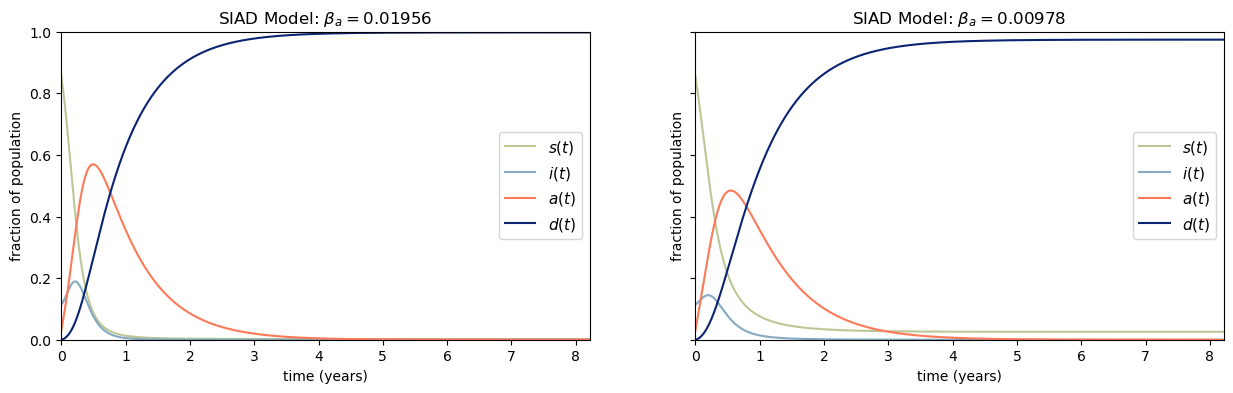

In [7]:
betai = 0.03749      # rate of transmission from infected to susceptible (/day)
betaa_hi = 0.01956      # rate of transmission from AIDS to susceptible (/day)
betaa_lo = 0.00978      # rate of transmission from AIDS to susceptible (/day)
lamda = 0.0301    # rate at which an infected person acquires aids (/day)
mu    = 0.004089  # rate at which an AIDS-acquired person passes away (/day)

fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(15,4))

# higher, original beta_a
params = np.array([[betai],[betaa_hi],[lamda],[mu]])
s,i_SIAD,a,d_SIAD,t = SIAD(s0, i0, a0, d0, t0, tf, delta_t, params)

ax[0].plot(t/365,s,color='#bdc696', label=f'$s(t)$');
ax[0].plot(t/365,i_SIAD,color='#84a9c0', label=f'$i(t)$');
ax[0].plot(t/365,a,color='#FC7A57', label=f'$a(t)$');
ax[0].plot(t/365,d_SIAD,color='#0A2472', label=f'$d(t)$');

ax[0].set_xlabel('time (years)');
ax[0].set_ylabel('fraction of population');
ax[0].legend(loc='center right', fontsize=11);
ax[0].set_ylim(0,1);
ax[0].set_xlim(t0,3000/365);
ax[0].set_title(r'SIAD Model: $\beta_a = 0.01956$');

# lower, adapted beta_a
params = np.array([[betai],[betaa_lo],[lamda],[mu]]);
s,i_SIAD,a,d_SIAD,t = SIAD(s0, i0, a0, d0, t0, tf, delta_t, params);
a_SIAD = copy.deepcopy(a);
s_SIAD = copy.deepcopy(s);

ax[1].plot(t/365,s,color='#bdc696', label=f'$s(t)$');
ax[1].plot(t/365,i_SIAD,color='#84a9c0', label=f'$i(t)$');
ax[1].plot(t/365,a,color='#FC7A57', label=f'$a(t)$');
ax[1].plot(t/365,d_SIAD,color='#0A2472', label=f'$d(t)$');

ax[1].set_xlabel('time (years)');
ax[1].set_ylabel('fraction of population');
ax[1].legend(loc='center right', fontsize=11);
ax[1].set_title(r'SIAD Model: $\beta_a = 0.00978$');

plt.savefig("CSCI7000_finalProj_SIAD.png", bbox_inches="tight", dpi=300)

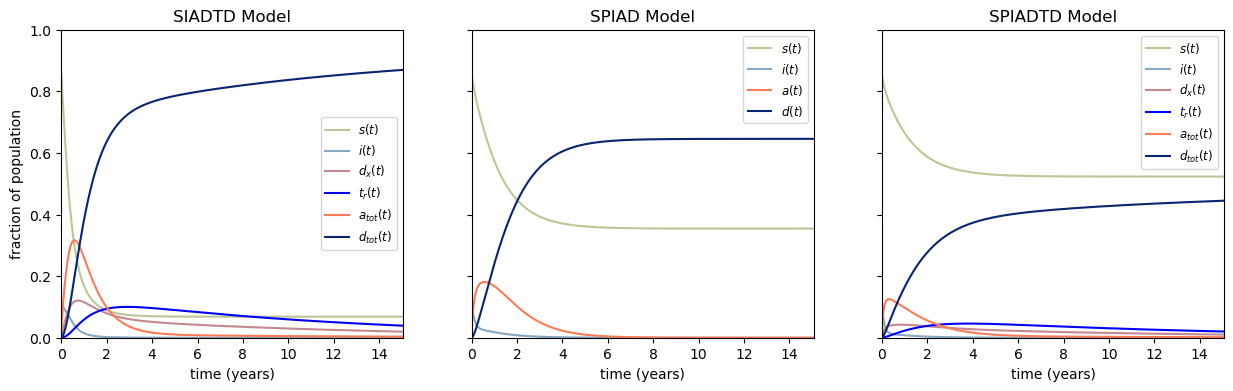

In [8]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,4))

# SPIAD model

betai = 0.03749      # rate of transmission from infected to susceptible (/day)
betaa = 0.00978      # rate of transmission from AIDS to susceptible (/day)
lamda = 0.0301       # rate at which an infected person acquires aids (/day)
mu    = 0.004089     # rate at which an AIDS-acquired person passes away (/day)
PE = 0.99
r = 0.6249

params = np.array([[betai],[betaa],[lamda],[mu],[PE],[r]])
s,i_SPIAD,a,d_SPIAD,t = SPIAD(s0, i0, a0, d0, t0, tf, delta_t, params)
a_SPIAD = copy.deepcopy(a)
s_SPIAD = copy.deepcopy(s)

ax[1].plot(t/365,s,color='#bdc696', label=f'$s(t)$')
ax[1].plot(t/365,i_SPIAD,color='#84a9c0', label=f'$i(t)$')
ax[1].plot(t/365,a,color='#fc7a57', label=f'$a(t)$')
ax[1].plot(t/365,d_SPIAD,color='#0a2472', label=f'$d(t)$')

ax[1].set_xlabel('time (years)')
# ax[1].set_ylabel('fraction of population')
ax[1].legend(loc='upper right', fontsize=8.5)
ax[1].set_ylim(0,1)
ax[1].set_xlim(t0,tf/365)
ax[1].set_title('SPIAD Model')

# SIADTD model

theta = 0.0101137
lamda_dx = 0.00068493
mu_dx = 0.004089
kappa = 0.00205479
xi = 0.00126028

params = np.array([[betai],[betaa],[lamda],[mu],[theta],[lamda_dx],[mu_dx],[kappa],[xi]])
s,i_SIADTD,a,d,dx,adx,ddx,tr,t = SIADTD(s0,i0,a0,d0,dx0,adx0,ddx0,tr0,t0,tf,delta_t,params)
d_tot_SIADTD = d+ddx
a_tot_SIADTD = copy.deepcopy(a+adx)

ax[0].plot(t/365,s,color='#bdc696', label=f'$s(t)$')
ax[0].plot(t/365,i_SIADTD,color='#84a9c0', label=f'$i(t)$')
ax[0].plot(t/365,dx,color='#C6878F', label=r'$d_{x}(t)$')
ax[0].plot(t/365,tr,color='#0000FF', label=r'$t_{r}(t)$')
ax[0].plot(t/365,a+adx,color='#FC7A57', label=r'$a_{tot}(t)$')
ax[0].plot(t/365,d_tot_SIADTD,color='#0a2472', label=r'$d_{tot}(t)$')

ax[0].set_xlabel('time (years)')
ax[0].set_ylabel('fraction of population')
ax[0].legend(loc='center right', fontsize=8.5)
ax[0].set_title('SIADTD Model')

# SPIADTD model

params = np.array([[betai],[betaa],[lamda],[mu],[theta],[lamda_dx],[mu_dx],[kappa],[xi],[PE],[r]])
s,i_SPIADTD,a,d,dx,adx,ddx,tr,t = SPIADTD(s0,i0,a0,d0,dx0,adx0,ddx0,tr0,t0,tf,delta_t,params)
d_tot_SPIADTD = d+ddx
a_tot_SPIADTD = copy.deepcopy(a+adx)

ax[2].plot(t/365,s,color='#bdc696', label=f'$s(t)$')
ax[2].plot(t/365,i_SPIADTD,color='#84a9c0', label=f'$i(t)$')
ax[2].plot(t/365,dx,color='#C6878F', label=r'$d_{x}(t)$')
ax[2].plot(t/365,tr,color='#0000FF', label=r'$t_{r}(t)$')
ax[2].plot(t/365,a+adx,color='#FC7A57', label=r'$a_{tot}(t)$')
ax[2].plot(t/365,d_tot_SPIADTD,color='#0A2472', label=r'$d_{tot}(t)$')

ax[2].set_xlabel('time (years)')
# ax[2].set_ylabel('fraction of population')
ax[2].legend(loc='upper right', fontsize=8.5)
ax[2].set_title('SPIADTD Model')

plt.savefig("CSCI7000_finalProj_SIAD_modelVars.png", bbox_inches="tight", dpi=300)

In [9]:
print(f'Difference between max a(t) values between SIAD and SIADTD: {(np.max(a_SIAD)-np.max(a_tot_SIADTD))*100:.2f}%')
print(f'Difference between max a(t) values between SIAD and SPIAD: {(np.max(a_SIAD)-np.max(a_SPIAD))*100:.2f}%')
print(f'Difference between max a(t) values between SIAD and SPIADTD: {(np.max(a_SIAD)-np.max(a_tot_SPIADTD))*100:.2f}%')

Difference between max a(t) values between SIAD and SIADTD: 16.81%
Difference between max a(t) values between SIAD and SPIAD: 30.36%
Difference between max a(t) values between SIAD and SPIADTD: 35.93%


In [10]:
print(f'Difference between max a(t) values between SIADTD and SPIAD: {(np.max(a_tot_SIADTD)-np.max(a_SPIAD))*100:.2f}%')
print(f'Difference between max a(t) values between SIADTD and SPIADTD: {(np.max(a_tot_SIADTD)-np.max(a_tot_SPIADTD))*100:.2f}%')

Difference between max a(t) values between SIADTD and SPIAD: 13.55%
Difference between max a(t) values between SIADTD and SPIADTD: 19.12%


In [11]:
print(f'Final s(t) for the SPIAD model: {(s_SPIAD[-1])*100:.2f}%')
print(f'Final s(t) for the SIAD model: {(s_SIAD[-1])*100:.2f}%')

Final s(t) for the SPIAD model: 35.43%
Final s(t) for the SIAD model: 2.57%


In [12]:
print(f'Difference between final d(t) values between SIAD and SPIAD: {(d_SIAD[-1]-d_SPIAD[-1])*100:.2f}%')
print(f'Final d(t) value for SPIADTD: {(d_tot_SPIADTD[-1])*100:.2f}%')
print(f'Difference between final d(t) values between SIAD and SPIADTD: {(d_SIAD[-1]-d_tot_SPIADTD[-1])*100:.2f}%')

Difference between final d(t) values between SIAD and SPIAD: 32.87%
Final d(t) value for SPIADTD: 44.48%
Difference between final d(t) values between SIAD and SPIADTD: 52.95%


0.9743304360746381
0.6456777618045136
0.44478817761717626
15.068493150684931


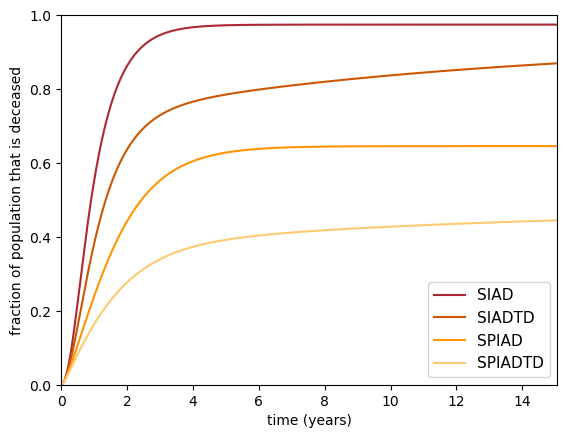

In [13]:
fig, ax = plt.subplots()

colors=np.array(['#ffc971', '#ff9505', '#cc5803', '#ad2831'])

ax.plot(t/365,d_SIAD,color=colors[3],label='SIAD')
ax.plot(t/365,d_tot_SIADTD,color=colors[2],label='SIADTD')
ax.plot(t/365,d_SPIAD,color=colors[1],label='SPIAD')
ax.plot(t/365,d_tot_SPIADTD,color=colors[0],label='SPIADTD')

ax.set_xlabel('time (years)')
ax.set_ylabel('fraction of population that is deceased')
plt.legend(loc='lower right', fontsize=11)
ax.set_ylim(0,1)
ax.set_xlim(t0,tf/365)

plt.savefig("CSCI7000_finalProj_allModels_deceased.png", bbox_inches="tight", dpi=300)

print(d_SIAD[-1])
print(d_SPIAD[-1])
print(d_tot_SPIADTD[-1])
print(t[-1]/365)

lost_societal_value_SIAD_without_treatment_cost: 112302473482200.83
lost_societal_value_SIAD: 112302473482298.16
lost_societal_value_SIADTD: 101004407652870.94
lost_societal_value_SPIAD: 74421579208004.44
lost_societal_value_SPIADTD: 52033816096653.11


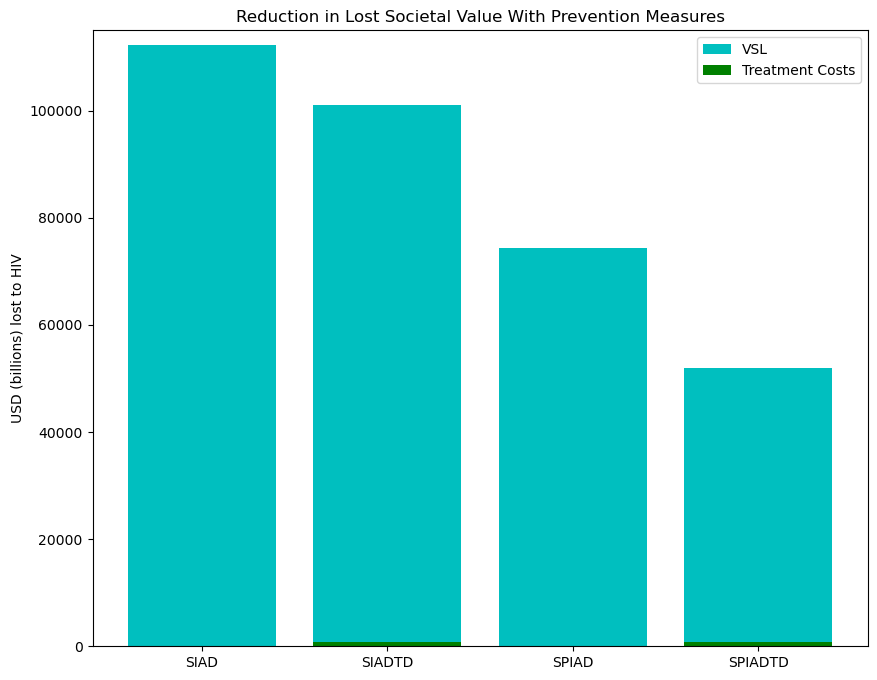

In [14]:
### economic analysis

key_population = 15E6
value_per_life_saved = 7684078.51
treatment_cost =448542.07
dollars_to_billion= 1e-9

#d_SIAD[-1]for the last death ratio at the end of the sim (so all lost societal value)
#end of sim treatment cost i[-1]
lost_societal_value_SIAD_without_treatment_cost = value_per_life_saved*key_population*d_SIAD[-1]
lost_societal_value_SIAD = value_per_life_saved*key_population*d_SIAD[-1]+(treatment_cost*key_population*i_SIAD[-1])
lost_societal_value_SIADTD = value_per_life_saved*key_population*d_tot_SIADTD[-1]+(treatment_cost*key_population*np.max(i_SIADTD))
lost_societal_value_SPIAD = value_per_life_saved*key_population*d_SPIAD[-1]
lost_societal_value_SPIADTD = value_per_life_saved*key_population*d_tot_SPIADTD[-1]+(treatment_cost*key_population*np.max(i_SPIADTD))


bins = ["SIAD", "SIADTD", "SPIAD", "SPIADTD"]
plt.figure(figsize=(10,8))
plt.bar(bins, [lost_societal_value_SIAD_without_treatment_cost*dollars_to_billion, 
               lost_societal_value_SIADTD*dollars_to_billion,
               lost_societal_value_SPIAD*dollars_to_billion,
               lost_societal_value_SPIADTD*dollars_to_billion], color='c', alpha=1, label="VSL")
plt.bar(bins, [0*dollars_to_billion, 
               (treatment_cost*key_population*np.max(i_SIADTD))*dollars_to_billion,
               0*dollars_to_billion,
               (treatment_cost*key_population*np.max(i_SPIADTD))*dollars_to_billion], color = "g", label="Treatment Costs")
# plt.xlabel(bins)
plt.legend()
plt.ylabel("USD (billions) lost to HIV")
plt.ylim([0,115000])
plt.title("Reduction in Lost Societal Value With Prevention Measures")
plt.savefig("EconomicAnalysis_prevention.png", bbox_inches="tight", dpi=300)
#use last number? to estimate the treatment cost so to capture the changes in the compartments and not overcount the infected compartment cost?

print("lost_societal_value_SIAD_without_treatment_cost:", lost_societal_value_SIAD_without_treatment_cost)
print("lost_societal_value_SIAD:", lost_societal_value_SIAD)
print("lost_societal_value_SIADTD:",lost_societal_value_SIADTD)
print("lost_societal_value_SPIAD:",lost_societal_value_SPIAD)
print("lost_societal_value_SPIADTD:",lost_societal_value_SPIADTD)

There are different perpectives you can take on measuring the economic impact of the epidemic. 
1. You can say that every person who does not die of AIDS is a life saved, and a positive 7.8M USD. In that case, the treatment is an added cost, a negative value, that is spent in order to save a life and "gain" the value of the life. 
2. You can also take a total of money lost from the HIV/AIDS epidemic and measure in each scenario how much the US government spends in total (money lost from death of an individual, and money spent and treatment to keep PLWH alive). In this case, both deaths and treatments are seen as an expense, and the value of the economic analysis is in the comparison between the total money spent in each scenario. 

In [15]:
# fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(12,10))

betai = 0.03749      # rate of transmission from infected to susceptible (/day)
betaa = 0.00978      # rate of transmission from AIDS to susceptible (/day)
lamda = 0.0301       # rate at which an infected person acquires aids (/day)
mu    = 0.004089     # rate at which an AIDS-acquired person passes away (/day)
theta_lo = 0.0101137
theta_hi = 0.02
lamda_dx = 0.00068493
mu_dx = 0.004089
kappa = 0.00205479
xi = 0.00126028
PE = 0.99
r_lo = 0.6249
r_hi = 0.9

# SPIADTD model - baseline

params = np.array([[betai],[betaa],[lamda],[mu],[theta_lo],[lamda_dx],[mu_dx],[kappa],[xi],[PE],[r_lo]])
s,i_SPIADTD,a,d,dx,adx,ddx,tr,t = SPIADTD(s0,i0,a0,d0,dx0,adx0,ddx0,tr0,t0,tf,delta_t,params)
d_tot_SPIADTD = d+ddx

# ax[0,0].plot(t,s,color='#bdc696', label=f'$s(t)$')
# ax[0,0].plot(t,i_SPIADTD,color='#84a9c0', label=f'$i(t)$')
# ax[0,0].plot(t,a+adx,color='#0a2472', label=r'$a_{tot}(t)$')
# ax[0,0].plot(t,d_tot_SPIADTD,color='#fc7a57', label=r'$d_{tot}(t)$')
# ax[0,0].plot(t,dx,color='k', label=r'$d_{x}(t)$')
# ax[0,0].plot(t,tr,color='g', label=r'$t_{r}(t)$')

# ax[0,0].set_xlim(t0,tf)
# ax[0,0].set_ylim(0,1)
# ax[0,0].set_xlabel('time (days)')
# ax[0,0].set_ylabel('fraction of population')
# ax[0,0].legend(loc='upper right', fontsize=8.5)
# ax[0,0].set_title('SPIADTD Model')

# SPIADTD model - improved adherence

params = np.array([[betai],[betaa],[lamda],[mu],[theta_lo],[lamda_dx],[mu_dx],[kappa],[xi],[PE],[r_hi]])
s,i_SPIADTD_hiAdherence,a,d,dx,adx,ddx,tr,t = SPIADTD(s0,i0,a0,d0,dx0,adx0,ddx0,tr0,t0,tf,delta_t,params)
d_tot_SPIADTD_hiAdherence = d+ddx

# ax[0,1].plot(t,s,color='#bdc696', label=f'$s(t)$')
# ax[0,1].plot(t,i_SPIADTD_hiAdherence,color='#84a9c0', label=f'$i(t)$')
# ax[0,1].plot(t,a+adx,color='#0a2472', label=r'$a_{tot}(t)$')
# ax[0,1].plot(t,d_tot_SPIADTD_hiAdherence,color='#fc7a57', label=r'$d_{tot}(t)$')
# ax[0,1].plot(t,dx,color='k', label=r'$d_{x}(t)$')
# ax[0,1].plot(t,tr,color='g', label=r'$t_{r}(t)$')

# # ax[0,1].set_xlabel('time (days)')
# # ax[0,1].set_ylabel('fraction of population')
# ax[0,1].legend(loc='upper right', fontsize=8.5)
# ax[0,1].set_title('SPIADTD Model: Improved Adherence')

# SPIADTD model - improved testing

params = np.array([[betai],[betaa],[lamda],[mu],[theta_hi],[lamda_dx],[mu_dx],[kappa],[xi],[PE],[r_lo]])
s,i_SPIADTD_hiTesting,a,d,dx,adx,ddx,tr,t = SPIADTD(s0,i0,a0,d0,dx0,adx0,ddx0,tr0,t0,tf,delta_t,params)
d_tot_SPIADTD_hiTesting = d+ddx

# ax[1,0].plot(t,s,color='#bdc696', label=f'$s(t)$')
# ax[1,0].plot(t,i_SPIADTD_hiTesting,color='#84a9c0', label=f'$i(t)$')
# ax[1,0].plot(t,a+adx,color='#0a2472', label=r'$a_{tot}(t)$')
# ax[1,0].plot(t,d_tot_SPIADTD_hiTesting,color='#fc7a57', label=r'$d_{tot}(t)$')
# ax[1,0].plot(t,dx,color='k', label=r'$d_{x}(t)$')
# ax[1,0].plot(t,tr,color='g', label=r'$t_{r}(t)$')

# # ax[1,0].set_xlabel('time (days)')
# # ax[1,0].set_ylabel('fraction of population')
# ax[1,0].legend(loc='upper right', fontsize=8.5)
# ax[1,0].set_title('SPIADTD Model: Improved Testing')

# SPIADTD model - improved adherence and testing

params = np.array([[betai],[betaa],[lamda],[mu],[theta_hi],[lamda_dx],[mu_dx],[kappa],[xi],[PE],[r_hi]])
s,i_SPIADTD_hiAdherence_hiTesting,a,d,dx,adx,ddx,tr,t = SPIADTD(s0,i0,a0,d0,dx0,adx0,ddx0,tr0,t0,tf,delta_t,params)
d_tot_SPIADTD_hiAdherence_hiTesting = d+ddx

# ax[1,1].plot(t,s,color='#bdc696', label=f'$s(t)$')
# ax[1,1].plot(t,i_SPIADTD_hiAdherence_hiTesting,color='#84a9c0', label=f'$i(t)$')
# ax[1,1].plot(t,a+adx,color='#0a2472', label=r'$a_{tot}(t)$')
# ax[1,1].plot(t,d_tot_SPIADTD_hiAdherence_hiTesting,color='#fc7a57', label=r'$d_{tot}(t)$')
# ax[1,1].plot(t,dx,color='k', label=r'$d_{x}(t)$')
# ax[1,1].plot(t,tr,color='g', label=r'$t_{r}(t)$')

# # ax[1,1].set_xlabel('time (days)')
# # ax[1,1].set_ylabel('fraction of population')
# ax[1,1].legend(loc='upper right', fontsize=8.5)
# ax[1,1].set_title('SPIADTD Model: Improved Adherence and Testing')

# plt.savefig("CSCI7000_finalProj_SPIADTD_adherence_testing-1.png", bbox_inches="tight", dpi=300)

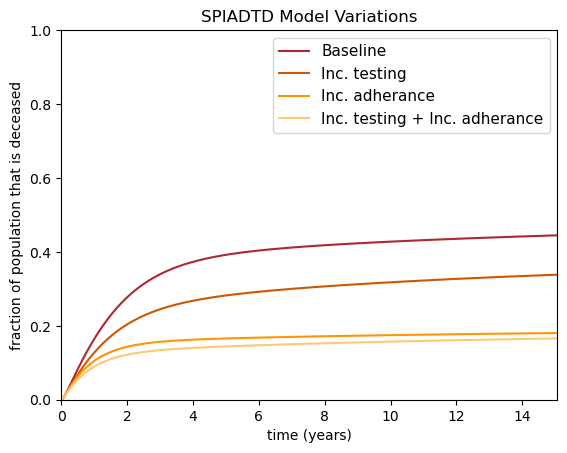

In [16]:
fig, ax = plt.subplots()

colors=np.array(['#ffc971', '#ff9505', '#cc5803', '#ad2831'])

ax.plot(t/365,d_tot_SPIADTD,color=colors[3],label='Baseline')
ax.plot(t/365,d_tot_SPIADTD_hiTesting,color=colors[2],label='Inc. testing')
ax.plot(t/365,d_tot_SPIADTD_hiAdherence,color=colors[1],label='Inc. adherance')
ax.plot(t/365,d_tot_SPIADTD_hiAdherence_hiTesting,color=colors[0],label='Inc. testing + Inc. adherance')

ax.set_xlabel('time (years)')
ax.set_ylabel('fraction of population that is deceased')
plt.legend(loc='upper right', fontsize=11)
ax.set_ylim(0,1)
ax.set_xlim(t0,tf/365)
ax.set_title('SPIADTD Model Variations')

# plt.savefig("CSCI7000_finalProj_SIAD_zoomedIn.png", bbox_inches="tight", dpi=300)
plt.savefig("CSCI7000_finalProj_SPIADTD_adherence_testing.png", bbox_inches="tight", dpi=300)

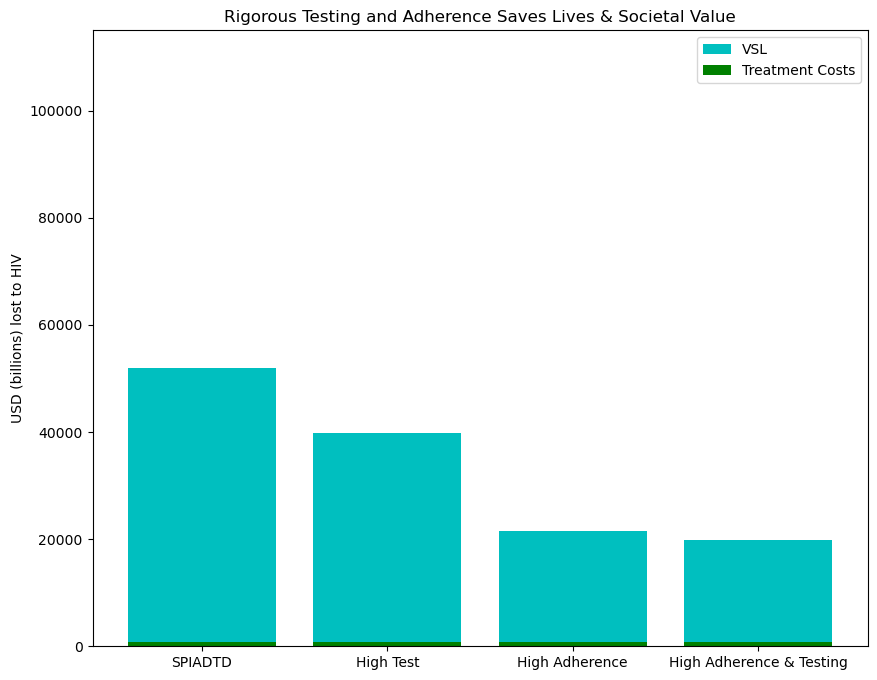

In [17]:
### economic analysis

key_population = 15E6
value_per_life_saved = 7684078.51
treatment_cost =448542.07
dollars_to_billion= 1e-9 

#d_SIAD[-1]for the last death ratio at the end of the sim (so all lost societal value)
#end of sim treatment cost i[-1]
lost_societal_value_SPIADTD = value_per_life_saved*key_population*d_tot_SPIADTD[-1]+(treatment_cost*key_population*np.max(i_SPIADTD))
lost_societal_value_SPIADTD_hiTesting = value_per_life_saved*key_population*d_tot_SPIADTD_hiTesting[-1]+(treatment_cost*key_population*np.max(i_SPIADTD_hiTesting))
lost_societal_value_SPIADTD_hiAdherence = value_per_life_saved*key_population*d_tot_SPIADTD_hiAdherence[-1]+(treatment_cost*key_population*np.max(i_SPIADTD_hiAdherence))
lost_societal_value_SPIADTD_hiAdherence_hiTesting = value_per_life_saved*key_population*d_tot_SPIADTD_hiAdherence_hiTesting[-1]+(treatment_cost*key_population*np.max(i_SPIADTD_hiAdherence_hiTesting))


bins = ["SPIADTD", "High Test", "High Adherence", "High Adherence & Testing"]
plt.figure(figsize=(10,8))
plt.bar(bins, [lost_societal_value_SPIADTD*dollars_to_billion, 
               lost_societal_value_SPIADTD_hiTesting*dollars_to_billion, 
               lost_societal_value_SPIADTD_hiAdherence*dollars_to_billion, 
               lost_societal_value_SPIADTD_hiAdherence_hiTesting*dollars_to_billion], color='c', alpha=1, label="VSL")
plt.bar(bins, [(treatment_cost*key_population*np.max(i_SPIADTD))*dollars_to_billion, 
               (treatment_cost*key_population*np.max(i_SPIADTD_hiTesting))*dollars_to_billion, 
               (treatment_cost*key_population*np.max(i_SPIADTD_hiAdherence))*dollars_to_billion, 
               treatment_cost*key_population*np.max(i_SPIADTD_hiAdherence_hiTesting)*dollars_to_billion], color = "g", label="Treatment Costs")
# plt.xlabel(bins)
plt.legend()
plt.ylabel("USD (billions) lost to HIV")
plt.ylim([0,115000])
plt.title("Rigorous Testing and Adherence Saves Lives & Societal Value")
plt.savefig("EconomicAnalysis_testAdherence.png", bbox_inches="tight", dpi=300)


#use last number? to estimate the treatment cost so to capture the changes in the compartments and not overcount the infected compartment cost?